#MIT 6.036 Spring 2019: Homework 10#

This colab notebook provides code and a framework for questions 2, 3, and 4 from [homework 10](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week10/week10_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.

In [1]:
import dist
import util
import code_for_hw10

import numpy as np
import math as m
import random

import pdb
from dist import uniform_dist, delta_dist, mixture_dist, DDist
from util import argmax_with_val, argmax
import mdp10 as mdp


2024-11-16 11:43:07.824416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 11:43:07.824958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 11:43:07.827483: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 11:43:07.836159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731753787.848035  597797 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731753787.85

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import importlib

# Exercice

In [3]:
S = {0, 1, 2, 3}
A = {'b', 'c'}
q = {(s,a):0 for s in S for a in A}

In [4]:
alpha = 0.5
gamma = 0.9

def update(s,a,r,ns):
  max_q = max([q[(ns,a)] for a in A])
  q_upd = (1-alpha)*q[(s,a)] + alpha*(r+gamma*max_q)
  q[(s,a)] = q_upd
  return q_upd

In [5]:
experience = [(0, 'b', 0), #t = 0
              (2, 'b', 0),
              (3, 'b', 2),
              (0, 'b', 0), #t = 3
              (2, 'b', 0),
              (3, 'c', 2),
              (0, 'c', 0), #t = 6
              (1, 'b', 1),
              (0, 'b', 0),
              (2, 'c', 0), #t = 9
              (3, 'c', 2),
              (0, 'c', 0),
              (1, 'c', 1), #t = 12
              (0, 'c', 0),
              (2, 'b', 0),
              (3, 'b', 2), #t = 15
              (0, 'b', 0),
              (2, 'c', 0),
              (3, '', 0), #t = 18
              ]

print(len(experience))

19


In [6]:
a = [0,0,0]
for k in range(len(experience)-1):
  (s,a,r) = experience[k]
  ns = experience[k+1][0]
  up = update(s,a,r,ns)
  print(q[s,a])

0.0
0.0
1.0
0.0
0.45
1.0
0.0
0.5
0.2025
0.45
1.591125
0.225
0.6012500000000001
0.315
0.9410062499999999
1.64175
0.5247028125
0.9637875


# 2) Implement Q-Learning

We'll work up to implementing the Q-learning algorithm by extending our code from HW9. In the next block, please copy and paste your implementations of the following functions from HW9.

In [7]:
def max_dict(q,new_q) :
  assert q.q.keys() == new_q.q.keys()
  max = 0
  for (s,a), q_value in q.q.items() :
    diff = abs(q_value - new_q.get(s,a))
    if (diff >= max) :
      max = diff
  return max

def value_iteration(mdp, q, eps=0.01, max_iters=1000):
  for iter in range(max_iters):
    new_q = q.copy()
    for (s,a), q_value in q.q.items():
      v = mdp.reward_fn(s,a)
      for next_s,p in mdp.transition_model(s,a).d.items() :
        v += mdp.discount_factor*p*value(q,next_s)
      new_q.set(s,a,v)
    if (max_dict(q,new_q) < eps) : return new_q
    else : q = new_q.copy()

def value(q, s):
    return max(q.get(s,a) for a in q.actions)

def greedy(q, s):
    return argmax(q.actions, lambda a: q.get(s, a))

def epsilon_greedy(q, s, eps = 0.5):
    if random.random() < eps:  # True with prob eps, random action
        return uniform_dist(q.actions).draw()
    else:
        return greedy(q,s)

Run the next code block to make sure what you need from HW9 is working.

In [8]:
mdp.value = value
mdp.greedy = greedy
mdp.epsilon_greedy = epsilon_greedy
mdp.value_iteration = value_iteration

importlib.reload(code_for_hw10)

# Test: Value Iteration
code_for_hw10.test_solve_play()

# Expected output:
# '''
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# '''

Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100


## 2.1) Q update

First, we'll extend our implementation of the TabularQ class in HW 9 (Problem 5) to incorporate the crucial operation of Q-learning, which is to update the Q value for a given `(s, a)` entry and move it part of the way towards a "target" value *t*.

> *Q(s,a) ← (1−α)Q(s,a) + αt*

Note that this can also be written as:

> *Q(s,a)← Q(s,a)+α(t−Q(s,a))*

That is, move a small (*α*) step towards t.

Let's define a new method for `TabularQ` that implements this, in a batched form. We will be given a list of `(s, a, t)` triples and have to do all the updates. Note that update is a method of the `TabularQ` class, so you can access the other methods and attributes.

* `data` is a list of `(s, a, t)` tuples.
* `lr` is a learning rate (*α* above)
* We will have to update `self.q[(s,a)]` for all of the data.


In [9]:
class TabularQ:
    def __init__(self, states, actions):
        self.actions = actions
        self.states = states
        self.q = dict([((s, a), 0.0) for s in states for a in actions])
    def copy(self):
        q_copy = TabularQ(self.states, self.actions)
        q_copy.q.update(self.q)
        return q_copy
    def set(self, s, a, v):
        self.q[(s,a)] = v
    def get(self, s, a):
        return self.q[(s,a)]
    def update(self, data, lr):
      for (s,a,t) in data :
          self.set(s,a,self.get(s,a) + lr*(t-self.get(s,a)))

## 2.2) Q_learn

Complete the definition of the `Q_learn` function. It should update the entries in the `q` function, `(s, a)`, towards their estimated Q values. It should terminate after `iters` iterations and use learning rate `lr`. Use the `q.update` method, which you just wrote, to update the Q values.

You will need to both simulate the agent's trajectory through the space as well as perform the updates to the Q function estimates. In this version, you should update the Q values after every transition, using a single `(s, a, t)` tuple. **The following methods and functions have already been defined for you.**


* To start a new simulation, call `mdp.init_state()`. That will draw a state from the MDP's initial state distribution.
* You can use the functions that we defined in HW 9: `epsilon_greedy` for action selection (epsilon_greedy takes `(q, s, eps = 0.5)` as input and returns an action) `value` takes `(q, s)` and returns the max Q value for a state.
* To take a step in the simulation, starting in a given state, `s`, using action a, call `mdp.sim_transition(s,a)`. It will return a pair `(r, s_prime)` denoting the reward received by the agent at that step and the next state.
* Be careful in treating terminal states. Recall that at a terminal state, there may be an immediate reward but the future expected value will be zero.
* Return `q` so that the Tutor can test it.

In [10]:
def Q_learn(mdp, q, lr=.1, iters=100, eps = 0.5, interactive_fn=None):
    s = mdp.init_state()
    for i in range(iters):
        a = epsilon_greedy(q,s,eps)
        r,ns = mdp.sim_transition(s,a)
        value_max = 0 if mdp.terminal(s) else value(q,ns)
        t = r + mdp.discount_factor*value_max
        data = [(s,a,t)]
        q.update(data,lr)
        s = ns
        if interactive_fn: interactive_fn(q, i)
    return q

Run the next code blocks to test your implementation of `Q_learn`.

score (0, 11.1)
score (10000, 12.7)
score (20000, 27.2)
score (30000, 15.6)
score (40000, 15.5)
score (50000, 21.1)
score (60000, 29.4)
score (70000, 21.5)
score (80000, 21.7)
score (90000, 38.8)
String to upload (incude quotes): "286c70300a4930310a614930300a61286c70310a2849300a4631312e310a7470320a61284931303030300a4631322e370a7470330a61284932303030300a4632372e320a7470340a61284933303030300a4631352e360a7470350a61284934303030300a4631352e350a7470360a61284935303030300a4632312e310a7470370a61284936303030300a4632392e340a7470380a61284937303030300a4632312e350a7470390a61284938303030300a4632312e370a747031300a61284939303030300a4633382e380a747031310a61612e"


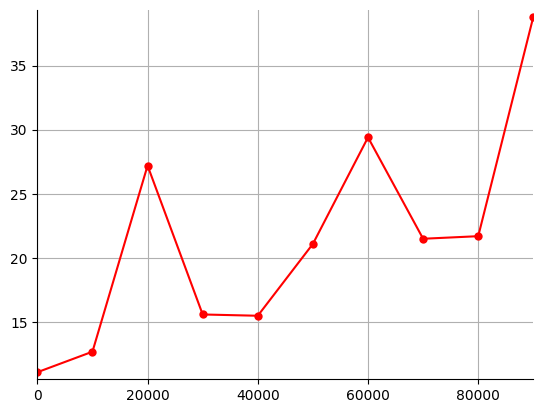

Reward 94
Reward 15
Reward 6
Reward 11
Reward 30
Reward 6
Reward 100
Reward 63
Reward 41
Reward 32


In [11]:
mdp.TabularQ = TabularQ
mdp.Q_learn = Q_learn

# Test: Tabular Q-learn
code_for_hw10.test_learn_play(iters=100000, tabular=True, batch=False)

In [12]:
def tinyTerminal(s):
    return s==4
def tinyR(s, a):
    if s == 1: return 1
    elif s == 3: return 2
    else: return 0
def tinyTrans(s, a):
    if s == 0:
        if a == 'a':
            return DDist({1 : 0.9, 2 : 0.1})
        else:
            return DDist({1 : 0.1, 2 : 0.9})
    elif s == 1:
        return DDist({1 : 0.1, 0 : 0.9})
    elif s == 2:
        return DDist({2 : 0.1, 3 : 0.9})
    elif s == 3:
        return DDist({3 : 0.1, 0 : 0.5, 4 : 0.4})
    elif s == 4:
        return DDist({4 : 1.0})

def testQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 0.6649739221724159), ((0, 'b'), 0.1712369526453748),
                ((1, 'a'), 0.7732751316011999), ((1, 'b'), 1.2034912054227331),
                ((2, 'a'), 0.37197205380133874), ((2, 'b'), 0.45929063274463033),
                ((3, 'a'), 1.5156163024818292), ((3, 'b'), 0.8776852768653631),
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]
    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")

random.seed(0)
testQ()

Tests passed!


## 2.3) Batch Q_learn

Assume your previous update method has been defined.

In the standard Q-learning algorithm, we make one epsilon-greedy transition based on the current Q estimate and then update the Q values. You can think of this as being like stochastic gradient descent. We can also define a version that is more like batch gradient descent, where we generate one or more "episodes" (sequences of transitions) using the current Q values and then update the Q values based on all the observed results. We can also keep around old transitions and use them (all or a random subset) in the update as well. **Note that as our Q value estimate evolves, the target Q value computed from a previously observed transition can change.**

Implement this version of batch Q-learning that (a) generates some specifed number of episodes of a given length (see `sim_episode` below), (b) adds these to the experiences we have seen previously, and (c) updates the Q estimates based on **all the experience so far**. Return `q` so that the Tutor can test it.

In [13]:
# evaluate this cell so you can use the definition in your code below

def sim_episode(mdp, episode_length, policy, draw=False):
    '''
    Simulate an episode (sequence of transitions) of at most
    episode_length, using policy function to select actions.  If we find
    a terminal state, end the episode.  Return accumulated reward a list
    of (s, a, r, s') where s' is None for transition from terminal state.
    Also return an animation if draw=True, or None if draw=False
    '''
    episode = []
    reward = 0
    s = mdp.init_state()
    all_states = [s]
    for i in range(episode_length):
        a = policy(s)
        (r, s_prime) = mdp.sim_transition(s, a)
        reward += r
        if mdp.terminal(s):
            episode.append((s, a, r, None))
            break
        episode.append((s, a, r, s_prime))
        if draw:
            mdp.draw_state(s)
        s = s_prime
        all_states.append(s)
    animation = animate(all_states, mdp.n, episode_length) if draw else None
    return reward, episode, animation

**Clarifications**

* There should be a SINGLE call to `q.update` per iteration, not per episode or per experience. Just one call per iteration, with a lot of data.
* Let's understand the distinction between experiences `(s, a, r, s')` and Q targets `(s, a, t)`. Note that experiences don't depend on the current estimated Q values (only on the environment we are acting in), but the "t" in the Q targets depends on the current Q values. So, it makes sense to store experiences across iterations, but not to store Q targets, since the Q targets change when we update our Q values. Thus, you want to continuously aggregate the experience and then, in each iteration, re-compute the Q targets under the current estimated Q values, then do the update with all of these Q targets. Here's pseudocode:


```
all_experiences = []
Loop over n_iterations:
    Loop over n_episodes:
        Generate an episode of length episode_length, append this experience to all_experiences
    all_q_targets = []
    Loop over all_experiences:
        Append Q target from one experience to all_q_targets
        Remember to handle terminal states (where s' = None)
    q.update(all_q_targets, lr)
return q
```



In [14]:
def Q_learn_batch(mdp, q, lr=.1, iters=100, eps=0.5,
                  episode_length=10, n_episodes=2,
                  interactive_fn=None):
    all_experiences = []
    for i in range(iters):
      for n in range(n_episodes):
        reward, episode, animation = sim_episode(mdp, episode_length, lambda x : epsilon_greedy(q,x,eps), draw=False)
        all_experiences += episode
      all_q_targets = []
      for (s,a,r,ns) in all_experiences :
        value_max = 0 if ns is None else value(q,ns)
        t = r + mdp.discount_factor*value_max
        all_q_targets.append((s,a,t))
      q.update(all_q_targets,lr)
      if interactive_fn: interactive_fn(q, i)
    return q

Run the next code blocks to test your implementation of `Q_learn_batch`.

score (0, 12.8)
score (1, 11.3)
score (2, 16.7)
score (3, 13.6)
score (4, 21.3)
score (5, 20.0)
score (6, 17.9)
score (7, 17.1)
score (8, 16.7)
score (9, 18.1)
String to upload (incude quotes): "286c70300a4930310a614930310a61286c70310a2849300a4631322e380a7470320a612849310a4631312e330a7470330a612849320a4631362e370a7470340a612849330a4631332e360a7470350a612849340a4632312e330a7470360a612849350a4632302e300a7470370a612849360a4631372e390a7470380a612849370a4631372e310a7470390a612849380a4631362e370a747031300a612849390a4631382e310a747031310a61612e"


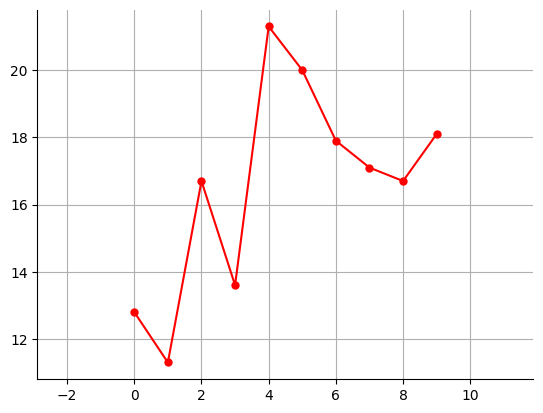

Reward 39
Reward 18
Reward 6
Reward 54
Reward 18
Reward 6
Reward 9
Reward 21
Reward 18
Reward 21


In [15]:
mdp.Q_learn_batch = Q_learn_batch
importlib.reload(code_for_hw10)

# Test: Tabular Batch Q-learn
code_for_hw10.test_learn_play(iters=10, tabular=True, batch=True) # Check: why do we want fewer iterations here?

In [16]:
def testBatchQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn_batch(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 4.7566600197286535), ((0, 'b'), 3.993296047838986),
                ((1, 'a'), 5.292467934685342), ((1, 'b'), 5.364014782870985),
                ((2, 'a'), 4.139537149779127), ((2, 'b'), 4.155347555640753),
                ((3, 'a'), 4.076532544818926), ((3, 'b'), 4.551442974149778),
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]

    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")

      return list(qf.q.items())

random.seed(0)
testBatchQ()

Tests passed!


[((0, 'a'), 4.7566600197286535),
 ((0, 'b'), 3.993296047838986),
 ((1, 'a'), 5.292467934685342),
 ((1, 'b'), 5.364014782870985),
 ((2, 'a'), 4.139537149779127),
 ((2, 'b'), 4.155347555640753),
 ((3, 'a'), 4.076532544818926),
 ((3, 'b'), 4.551442974149778),
 ((4, 'a'), 0.0),
 ((4, 'b'), 0.0)]

# 3) NN Q: Using neural networks to store the Q function

We would like to operate in large or continuous state and/or action
spaces so it is not possible (or effective) to store the $Q$ values in
a table as we did with the <tt>TabularQ</tt> class; instead, we will
"store" them by training a neural network to do regression for us,
taking $s,a$ as input and generating (an approximation of) $Q^*(s,a)$
as output.

To train the network, we will use <i>squared Bellman error</i> as
the loss function:
$$\left(\left[R(s_t, a_t) + \gamma \max_{a'} Q(s_{t+1}, a'; \theta)\right]
- Q(s_t, a_t;\theta) \right)^2$$
where $\theta$ stands for the current weights in the neural network
and $Q(s, a; \theta)$ stands for the output of the network with
weights $\theta$ when $(s,a)$ is the input.

There are many choices of neural network architecture for storing Q
values.  In this problem, we will:

<ul>

<li> Focus on the case where we have a small set of possible actions,
so make one neural network for each possible action <math>a</math>;

<li> Design that network with two <b>hidden</b> layers with ReLU units
and a single linear output unit (although a deeper network could be
useful); and

<li> Use mean squared error (MSE) as the loss function since, we are
predicting continuous <math>Q</math> values, which is a regression
problem.

</ul>

To use a neural net to store Q values, for a given action, we will
need to have a mapping from states to fixed-length vectors.  We will
assume that the <code>MDP</code> class has a <code>state2vec</code>
method that maps states to vectors.  For the simple discrete-state
MDPs we have seen so far, this simply returns a one-hot representation
of the state.

For reference, this is our implementation of
<code>state2vec</code> (note the shape of its returned array):
<pre>
    def state2vec(self, s):
        '''
        Return one-hot encoding of state s; used in neural network agent implementations
        '''
        v = np.zeros((1, len(self.states)))
        v[0,self.states.index(s)] = 1.
        return v
</pre>

Now, all we need to do is write a new class, called <code>NNQ</code>
to implement neural-network version of Q-function storage; then we can
pass an <code>NNQ</code> instance instead of a <code>TabularQ</code> instance
into <code>Q_learn</code> or <code>Q_learn_batch</code>, and
we will automatically have reinforcement learning with neural
networks!

There are three methods to implement in our <code>NNQ</code>
class. Here are some ideas for how to do that:
<ul>

<li> <code>__init__</code>: Create one neural network for each action,
and store them in <tt>self.models</tt>. Note that <tt>actions</tt> is
a list that may consist of integers or strings or other objects.  As a
reminder, here's how to make a new feed-forward network using Keras:


In [17]:
# please evaluate this cell so you can use it in your code

def make_nn(state_dim, num_hidden_layers, num_units):
    '''
    state_dim =	(int) number of states
    num_hidden_layers =	(int) number of	fully connected hidden layers
    num_units =	(int) number of	dense relu units to use	in hidden layers
    '''
    model = Sequential()
    model.add(Dense(num_units, input_dim = state_dim, activation='relu'))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam())
    return model

<ul>
<li> <code>get(self, s, a)</code>: Use the neural network you have
stored for action <code>a</code> to predict a Q value for state
<code>s</code>. Feel free to consult documentation on the
<a href="https://keras.io/models/model/#predict">Keras model predict</a>
method.</li>

<li> <code>update(self, data, lr, epochs = 1)</code>: As in
<code>TabularQ</code>, <code>data</code> is a list of <code>(s, a,t)</code>
tuples, where <code>t</code> is a target Q value.  For each
action <code>a</code>, you will need to:

  <ul>
  <li> Construct a training set <code>X, Y</code> of data that is
  relevant to action <code>a</code>, where the input values are states
  (encoded as vectors) and the output values are the target Q values;</li>

  <li> Use the Keras method <code>fit(self, X, Y, epochs=epochs)</code>
  to update the weights in th e associated network.  You can ignore
  the <tt>lr</tt> input parameter, and let Adam in keras manage the
  learning rate.</li>
  </ul>
</li>
</ul>

In [18]:
# Complete the following definition to implement the NNQ class

class NNQ:
    def __init__(self, states, actions, state2vec, num_layers, num_units, epochs=1):
        self.actions = actions
        self.states = states
        self.state2vec = state2vec
        self.epochs = epochs
        self.models = {a: make_nn(state2vec(states[0]).shape[1], num_layers, num_units) for a in actions}
    def get(self, s, a):
        return self.models[a].predict(self.state2vec(s))
    def update(self, data, lr):
        for a in self.actions:
            if [s for (s, at, t) in data if a==at]:
                X = np.vstack([self.state2vec(s) for (s, at, t) in data if a==at])
                Y = np.vstack([t for (s, at, t) in data if a==at])
                self.models[a].fit(X, Y, epochs = self.epochs, verbose = False)


Run the next code blocks to test your implementation of `NNQ`:

In [ ]:
mdp.NNQ = NNQ
importlib.reload(code_for_hw10)

# Test: NN Q-learn
code_for_hw10.test_learn_play(iters=100000, tabular=False, batch=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-16 11:43:11.395848: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [ ]:
def test_NNQ(data):
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = NNQ(tiny.states, tiny.actions, tiny.state2vec, 2, 10)
    q.update(data, 1)
    ret =  [q.get(s,a) for s in q.states for a in q.actions]
    expect = [np.array([[-0.07211456]]), np.array([[-0.19553234]]),
              np.array([[-0.21926211]]), np.array([[0.01699455]]),
              np.array([[-0.26390356]]), np.array([[0.06374809]]),
              np.array([[0.0340214]]), np.array([[-0.18334733]]),
              np.array([[-0.438375]]), np.array([[-0.13844737]])]
    cnt = 0
    ok = True
    for s in q.states:
      for a in q.actions:
        if not np.all(np.abs(ret[cnt]-expect[cnt]) < 1.0e0):
          print("Oops, for s=%s, a=%s expected %s but got %s" % (s, a, expect[cnt], ret[cnt]))
          ok = False
        cnt += 1
    if ok:
      print("Output looks generally ok")
    return q

test_NNQ([(0,'a',0.3),(1,'a',0.1),(0,'a',0.1),(1,'a',0.5)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Output looks generally ok


## 3.2) Fitted Q iteration

*Fitted Q iteration (FQ)* suffers less from the correlated experience problem and is generally more stable (and sometimes slower) than NNQ.

FQ initializes the Q networks and an empty data set, then operates in a loop:

1. Use *ϵ*-greedy exploration to generate *k* steps of experience, of the form *(s,a,r,s′)* and add them to the data set.
2. Create one training set for each action *a*:

> 1. Extract all the tuples from your data set that contain action *a*,
> 2. Let the *X* values of your training set be all of the *s* values from your data tuples with action *a* and the *Y* values be the *r + γ max_a' Q(s', a')* values computed for each data tuple, using the Q estimates from the current network.

3. Train the network for action *a* for several epochs until it has done a good job of representing this data.

So, this is basically `Q_learn_batch` using `NNQ` (training with multiple epochs) to implement the Q function.

Run the next code block to test your implementation of `NNQ` with batching.

In [ ]:
# Test: NN Batch Q-learn (Fitted Q-learn)
code_for_hw10.test_learn_play(iters=10, tabular=False, batch=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

#4) No Exit

Please read the instructions in the [homework](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Spring/courseware/Week10/week10_homework/) to set up for the game. You may use this space to display the game in Colab.

For each of the learning method and Q model combinations below,
solve the game so that it reliably gets to reward of 100 (that is, the
learned game reliably plays 100 steps without missing the ball,
earning a score of 100).  During learning, you should see a sequence
of lines like: <code>score (5000, 37.5)</code>, which indicates that
after 5000 iterations the average reward over 10 games is 37.5.  We
are checking whether you reach a solution that gets an average reward
100 at least one time. Try playing around with the number of
iterations (an argument to <code>test_learn_play</code>) until you
achieve this point. Note that we will need fewer iterations for
Q_learn_batch, in general (check yourself: why?). After learning, the
code prints a long "upload string" in HEX code.  Enter the upload
strings in the question boxes in the homework MITx site.

In [ ]:
# Value Iteration
code_for_hw10.test_solve_play(draw = True)

In [ ]:
# Tabular Q-learn
code_for_hw10.test_learn_play(draw=True, iters=100000, tabular=True, batch=False)

In [ ]:
# Tabular Batch Q-learn
code_for_hw10.test_learn_play(draw=True, iters=10, tabular=True, batch=True) # Check: why do we want fewer iterations here?

In [ ]:
# NN Q-learn
code_for_hw10.test_learn_play(draw=True, iters=100000, tabular=False, batch=False)

In [ ]:
# NN Batch Q-learn (Fitted Q-learn)
code_for_hw10.test_learn_play(draw=True, iters=10, tabular=False, batch=True)